# AutoPulseSynth single qubit pulse synthesis baseline (simulated)

The notebook is a **reproducible** baseline for synthesizing **single qubit** control pulses  
for **X** and **SX** gates under a **fixed, physically meaningful Hamiltonian** with **parameter uncertainty**.

**Idea:**  
Given a target gate (X or SX), synthesize constrained pulses that maximize **average gate fidelity** under a simulator.  
Performance under parameter variation is tested by sweeping uncertain Hamiltonian parameters $\\theta$.


## Concepts

- **Pulse synthesis / quantum optimal control**: choosing time dependent control fields  
  $\\Omega_x(t), \\Omega_y(t)$ so that the system’s unitary evolution $U(T)$ matches a target gate $V$.

- **Fixed Hamiltonian structure**: I kept the *form* of the Hamiltonian fixed (drift + drives on Pauli operators).  
  I did **not** fit an arbitrary Hamiltonian.

- **Parameter uncertainty $\\theta$**: imperfect calibration/physics is represented by uncertain parameters  
  (detuning, drive scale, etc.). Uncertainty aware optimization attempts to perform well across a distribution  
  of $\\theta$, not just at nominal settings.

## Related Work

- **GRAPE** (Gradient Ascent Pulse Engineering): classic gradient-based quantum optimal control.  
- **Krotov methods**: monotonic convergence optimal control with constraints.  
- **ML-accelerated quantum control**: surrogate models / reinforcement learning / Bayesian optimization to reduce simulation cost.


In [23]:
# Environment setup
import sys, os, json, platform, math
import numpy as np
import matplotlib.pyplot as plt

print("Python:", sys.version)
print("Platform:", platform.platform())

# Ensuring I can import the package from the repo root if running this notebook in place
repo_root = os.path.abspath("..") if os.path.isdir("../autopulsesynth") else os.path.abspath(".")
sys.path.insert(0, repo_root)

import autopulsesynth as aps

SEED = 7
np.random.seed(SEED)


Python: 3.10.14 (main, Jul 25 2025, 15:19:35) [Clang 17.0.0 (clang-1700.0.13.5)]
Platform: macOS-15.5-arm64-arm-64bit


# Physical model

I simulate a driven single qubit in a (rotating frame) model:

$$
H(t) = \frac{\Delta}{2}\sigma_z
     + \frac{\Omega_x(t)}{2}\sigma_x
     + \frac{\Omega_y(t)}{2}\sigma_y
$$

- $\Delta$ (**detuning**, rad/s) is the drift term (frequency offset in the rotating frame).
- $\Omega_x(t), \Omega_y(t)$ (rad/s) are the control drives along $x$ and $y$.

## Uncertainty parameters $\theta$

I ddid not change the Hamiltonian structure; just varied parameters:

$$
\theta =
[\text{detuning},\; \text{amp\_scale},\; \text{phase\_skew},\; \text{noise\_strength}]
$$

- **detuning**: additive detuning (rad/s)
- **amp_scale**: multiplicative drive scaling error (dimensionless)
- **phase_skew**: small IQ mixing / quadrature skew (dimensionless)
- **noise_strength**: quasi-static detuning noise std (rad/s) per shot

Performance under parameter variation tests sweep these parameters.

In [24]:
model = aps.QubitHamiltonianModel()

MHz = 1e6 * 2 * np.pi  # convert MHz -> rad/s
uncertainty = aps.UncertaintyModel(
    detuning_min=-2.0 * MHz,
    detuning_max=+2.0 * MHz,
    scale_min=0.95,
    scale_max=1.05,
    skew_min=-0.02,
    skew_max=0.02,
    noise_min=0.0,
    noise_max=0.2 * MHz,
    rng_seed=SEED,
)
theta_nom = uncertainty.nominal()
print("Nominal theta:", aps.UncertaintyModel.theta_to_dict(theta_nom))


Nominal theta: {'detuning': 0.0, 'amp_scale': 1.0, 'phase_skew': 0.0, 'noise_strength': 628318.5307179586}


# Pulse family and its constraints

I used **Gaussian envelope** and **DRAG like** quadrature.

Pulse parameters:  
$p = [A, t_0, \sigma, \phi, \beta]$

Constraints:
- Max amplitude `amp_max` on each quadrature
- Minimum width `sigma_min`
- Fixed duration and sample count


Pulse param bounds [A, t0, sigma, phi, beta]:
lo: [ 0.00000000e+00  0.00000000e+00  2.00000000e-09 -3.14159265e+00
 -2.00000000e+00]
hi: [3.14159265e+08 4.00000000e-08 2.00000000e-08 3.14159265e+00
 2.00000000e+00]


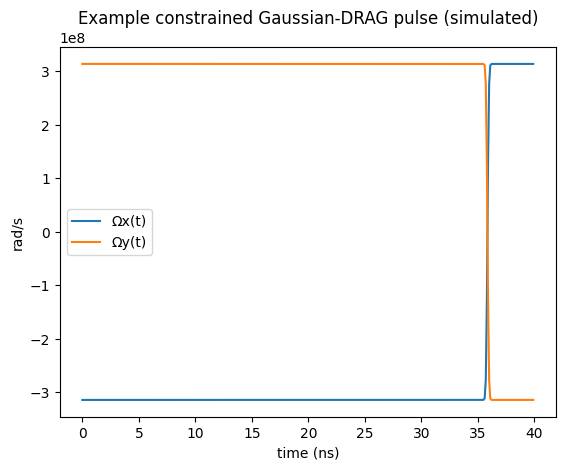

In [25]:
# Choose a short pulse duration typical of single-qubit gates (simulated baseline)
duration = 40e-9  # 40 ns
n_steps = 400     # 0.1 ns step
amp_max = 2 * np.pi * 50e6  # 50 MHz in rad/s
sigma_min = 2e-9

pulse_family = aps.GaussianDragPulse(duration=duration, n_steps=n_steps, amp_max=amp_max, sigma_min=sigma_min)

lo, hi = pulse_family.param_bounds()
print("Pulse param bounds [A, t0, sigma, phi, beta]:")
print("lo:", lo)
print("hi:", hi)

# Visualize one random pulse
rng = np.random.default_rng(SEED)
params_demo = rng.uniform(lo, hi)
ox, oy = pulse_family.sample_controls(params_demo, smooth_sigma_pts=1.0)
t = pulse_family.time_grid()

plt.figure()
plt.plot(t * 1e9, ox, label="Ωx(t)")
plt.plot(t * 1e9, oy, label="Ωy(t)")
plt.xlabel("time (ns)")
plt.ylabel("rad/s")
plt.title("Example constrained Gaussian-DRAG pulse (simulated)")
plt.legend()
plt.show()


# Simulation and fidelity metric

I simulate the unitary evolution \(U(T)\) under the Hamiltonian using **QuTiP**.

To compare an implemented unitary \(U\) to a target gate \(V\), I used **average gate fidelity**
for dimension \(d=2\):

$$
F_{avg}(U,V) = \frac{|\mathrm{Tr}(V^\dagger U)|^2 + d}{d(d+1)}
$$

This metric equals 1 for perfect implementation (up to global phase).


In [26]:
from autopulsesynth.simulate import target_unitary

Vx = target_unitary("X")
Vsx = target_unitary("SX")

# Simulate fidelity for the demo pulse at nominal theta
U_demo = aps.simulate_unitary(model, duration, ox, oy, theta_nom)
f_demo_x = aps.average_gate_fidelity(U_demo, Vx)
f_demo_sx = aps.average_gate_fidelity(U_demo, Vsx)

print("Simulated fidelities (nominal theta):")
print("  F_avg vs X :", f_demo_x)
print("  F_avg vs SX:", f_demo_sx)


Simulated fidelities (nominal theta):
  F_avg vs X : 0.497062123049933
  F_avg vs SX: 0.3486860954800397


# Baseline: random pulses

Random baseline (nominal theta), gate: X
  mean F: 0.5005367569984408
  best F: 0.6678126392940253


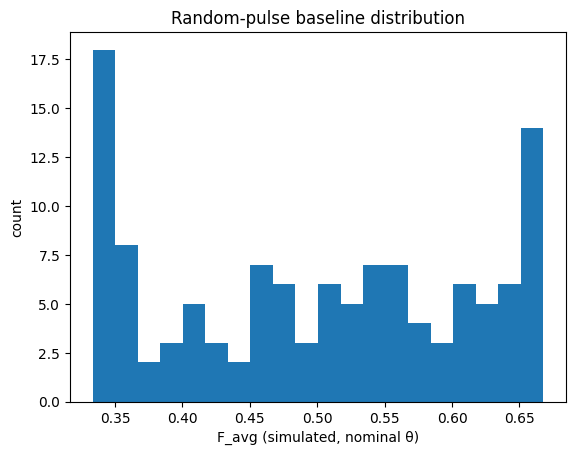

In [27]:
def eval_params_nominal(params, gate="X", smooth_sigma_pts=1.0):
    ox, oy = pulse_family.sample_controls(params, smooth_sigma_pts=smooth_sigma_pts)
    U = aps.simulate_unitary(model, duration, ox, oy, theta_nom)
    V = target_unitary(gate)
    return aps.average_gate_fidelity(U, V)

rng = np.random.default_rng(SEED)
n_random = 120
gate = "X"

fs = []
params_list = []
for _ in range(n_random):
    p = rng.uniform(lo, hi)
    f = eval_params_nominal(p, gate=gate)
    fs.append(f)
    params_list.append(p)

fs = np.array(fs)
best_idx = int(np.argmax(fs))
best_random_params = params_list[best_idx]
print("Random baseline (nominal theta), gate:", gate)
print("  mean F:", float(np.mean(fs)))
print("  best F:", float(np.max(fs)))

plt.figure()
plt.hist(fs, bins=20)
plt.xlabel("F_avg (simulated, nominal θ)")
plt.ylabel("count")
plt.title("Random-pulse baseline distribution")
plt.show()


# Dataset generation with Hamiltonian uncertainty

I build a dataset of $(p,\theta) \to F$ by sampling:
- pulse parameters $p$ from bounds
- uncertainty parameters $\theta$ from the uncertainty model

This dataset is used to train a surrogate model that approximates simulation fidelity.

In [28]:
gate = "X"  # change to "SX" for sqrt(X)
n_pulses = 90
n_theta_per_pulse = 24

dataset = aps.SurrogateDataset.build(
    pulse_family=pulse_family,
    model=model,
    uncertainty=uncertainty,
    gate=gate,
    n_pulses=n_pulses,
    n_theta=n_theta_per_pulse,
    rng_seed=SEED,
    smooth_sigma_pts=1.0,
)

print("Dataset shapes:")
print("  X:", dataset.X.shape, "(features)")
print("  y:", dataset.y.shape, "(fidelity)")
print("Fidelity range:", float(dataset.y.min()), "to", float(dataset.y.max()))


Dataset shapes:
  X: (2160, 11) (features)
  y: (2160,) (fidelity)
Fidelity range: 0.33333414380687265 to 0.6860731765777249


# Surrogate model training and validation metrics

I train a **RandomForestRegressor** as a stable, nonparametric surrogate.
It is not the only choice, but it works well for small-to-medium tabular datasets and is easy to reproduce.

I report:
- MAE (mean absolute error)
- R² on a held-out split


In [29]:
surrogate, metrics = aps.train_surrogate(dataset, rng_seed=SEED)
print("Surrogate metrics (held out):")
for k, v in metrics.items():
    print(f"  {k}: {v:.6f}")


Surrogate metrics (held out):
  mae: 0.014009
  r2: 0.968659
  y_test_mean: 0.503945


# Uncertainty aware pulse optimization loop (surrogate)

I optimize pulse parameters on the surrogate objective across sampled $\theta$:

- **mean** mode: maximize average predicted fidelity across $\theta$
- **worst** mode: maximize worst case predicted fidelity across $\theta$ (more conservative)

Then I **verify** the candidate pulse in the full QuTiP simulator.

In [30]:
mode = "worst"  # "mean" or "worst"

opt_summary = aps.optimize_under_uncertainty(
    pulse_family=pulse_family,
    surrogate=surrogate,
    uncertainty=uncertainty,
    mode=mode,
    n_theta_eval=64,
    rng_seed=SEED + 1,
)

best_params = opt_summary["best_params"]
print("Optimized params:", best_params)
print("Surrogate predicted fidelity across parameter variation:")
print("  predicted mean :", opt_summary["pred_f_mean"])
print("  predicted worst:", opt_summary["pred_f_worst"])


Optimized params: [ 1.37655014e+08  2.36178545e-08  1.46971545e-08 -1.22446760e+00
  1.89982581e+00]
Surrogate predicted fidelity across parameter variation:
  predicted mean : 0.6609527062759155
  predicted worst: 0.6501929403447203


# Final verification in full simulator (simulated)

I evaluate the optimized pulse on a fresh set of $\theta$ samples using the full simulator.  

In [31]:
from autopulsesynth.optimize import verify_in_simulator

verify = verify_in_simulator(
    model=model,
    pulse_family=pulse_family,
    params=best_params,
    uncertainty=uncertainty,
    gate=gate,
    n_theta=220,
    rng_seed=SEED + 2,
    smooth_sigma_pts=1.0,
)

print("Full simulator verification (simulated):")
print("  mean F :", verify["f_mean"])
print("  worst F:", verify["f_worst"])
print("  std F  :", verify["f_std"])


Full simulator verification (simulated):
  mean F : 0.6648118583752372
  worst F: 0.6388159771750708
  std F  : 0.00958227727241291


/Users/haber/CSProjects/AutoPulseSynth/.venv/lib/python3.10/site-packages/qutip/solver/options.py:16: FutureWarning: Dedicated options class are no longer needed, options should be passed as dict to solvers.
  warnings.warn(


# performance under parameter variation sweeps and plots (simulated)

I inspect fidelity vs:
- detuning
- amplitude scale error

Then I compute fidelity on a grid while holding other parameters at nominal values.


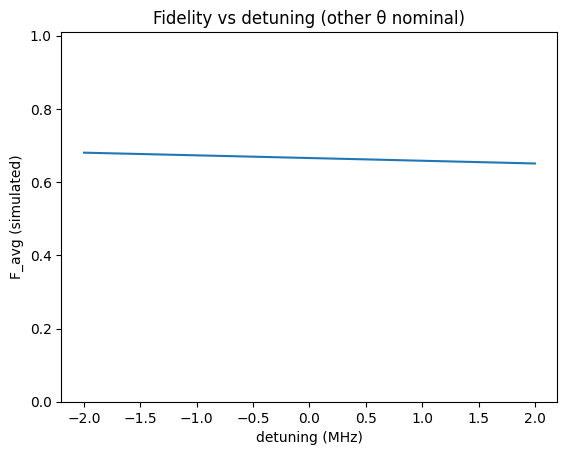

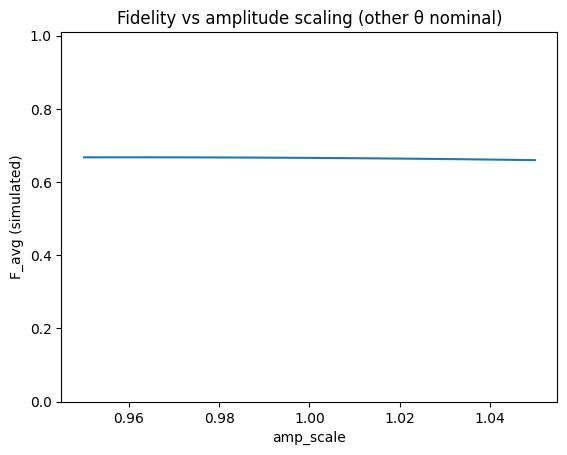

In [32]:
V = target_unitary(gate)
ox_best, oy_best = pulse_family.sample_controls(best_params, smooth_sigma_pts=1.0)

# Sweep detuning
det_grid = np.linspace(uncertainty.detuning_min, uncertainty.detuning_max, 41)
f_det = []
for det in det_grid:
    theta = theta_nom.copy()
    theta[0] = det
    U = aps.simulate_unitary(model, duration, ox_best, oy_best, theta)
    f_det.append(aps.average_gate_fidelity(U, V))
f_det = np.array(f_det)

plt.figure()
plt.plot(det_grid / (2*np.pi*1e6), f_det)
plt.xlabel("detuning (MHz)")
plt.ylabel("F_avg (simulated)")
plt.title("Fidelity vs detuning (other θ nominal)")
plt.ylim(0.0, 1.01)
plt.show()

# Sweep amplitude scale
scale_grid = np.linspace(uncertainty.scale_min, uncertainty.scale_max, 41)
f_scale = []
for s in scale_grid:
    theta = theta_nom.copy()
    theta[1] = s
    U = aps.simulate_unitary(model, duration, ox_best, oy_best, theta)
    f_scale.append(aps.average_gate_fidelity(U, V))
f_scale = np.array(f_scale)

plt.figure()
plt.plot(scale_grid, f_scale)
plt.xlabel("amp_scale")
plt.ylabel("F_avg (simulated)")
plt.title("Fidelity vs amplitude scaling (other θ nominal)")
plt.ylim(0.0, 1.01)
plt.show()


# Export optimized pulse

I export:
- JSON spec containing pulse parameters and sampled waveforms (Ωx, Ωy)


In [33]:
export_path = os.path.join("..", "optimized_pulse.json") if os.path.isdir("..") else "optimized_pulse.json"
spec = aps.export_pulse_json(pulse_family, best_params, export_path, smooth_sigma_pts=1.0)
print("Exported JSON to:", export_path)
print("Spec keys:", list(spec.keys()))


Exported JSON to: ../optimized_pulse.json
Spec keys: ['pulse_family', 'pulse_params', 'samples', 'notes']


# Limitations and assumptions

This is a baseline, not a full control stack.

- **Model simplification**: rotating-frame driven qubit with detuning + x/y drives. No leakage levels, no amplitude-dependent frequency shifts, no bandwidth-limited transfer function.
- **Noise model**: quasi-static detuning noise only. No Markovian dissipation, no colored noise.
- **Pulse family**: single Gaussian-DRAG segment. More expressive families (piecewise controls, splines, Fourier) can improve performance.
- **Optimization**: surrogate-assisted global search; not guaranteed to match GRAPE/Krotov efficiency.
- **Fidelity metric**: unitary-only average gate fidelity; does not include decoherence.


## Extension roadmap
- Phase 2: two-qubit entangling gate pulse synthesis (fixed coupling Hamiltonian + uncertainty-aware search)
- Phase 3: FastAPI backend exposing `/synthesize` and `/analyze`
- Phase 4: Next.js/React frontend for interactive pulse design
- Phase 5: hardware-in-the-loop calibration integration
